# 4.1 Logistic Regression

---
> Erick Eduardo Aguilar Hernández:
> * mat.ErickAguilar@gmail.com.mx
> * isc.ErickAguilar@gmail.com

Consider two populations $\Omega_1$, $\Omega_2$ with their random vectors of features associated $\mathbf{x_1},\mathbf{x_2} \in \mathbb{R}^p$, a discriminant is a function $D:\mathbb{R}^p \rightarrow \mathbb{R}$ such that if $D(\mathbf{x}) \geq t$ for some threshold $t \in \mathbb{R}$ then asign $\mathbf{x}$ to $\Omega_1$ otherwise $\mathbf{x}$ to $\Omega_2$. D its a linear discriminant if D has the form:

$$D(\mathbf{x})=\beta_0+\beta_1 x_1 + \dots \beta_p x_p = \beta_0+\mathbf{x' \beta}$$

### Logistic Model
___

Consider the following random vector $(Y,X_1,\dots,Y_p) \in {0,1} \times \mathbb{R}^p$, where $Y$ is and indicator variable and this take the value 1 if the random vector belong to the population $\Omega_1$ and 0 if it belongs to $\Omega_2$, so it make sense that the probability of belonging to $\Omega_1$ (objetive population) sould be parametrized by a discriminant D, where D its a linear combination of features and weights:

$$P[Y=Y|X_1=x_1,\dots,X_p=x_p]=p(D)=p(\mathbf{x};\beta_0,\mathbf{\beta})$$

The logistic model establishes that the increase in the probability of belonging to the population $\Omega_1$ with respect to discriminant D is directly proportional to the probability of belonging to $\Omega_1$ given D and decreases as it approach to 1. 

$$ \frac{p'}{p}=1-p$$

Tha idea its try to solve this differential equation in order to put $p$ as function of the values of D.

$$
\begin{align*}
\frac{p'}{p} &= 1-p\\
p' &= p(1-p)\\
\frac{dp}{dD} &= p(1-p)\\
\frac{dp}{p(1-p)}&=dD\\
\int \frac{dp}{p(1-p)}&=\int dD\\
\int \frac{dp}{p-p^2}&=D\\
\end{align*}
$$

Note that the constant of the integral in the right side couuld be absorved by the intercepto of D, and the only problem its try to solve the left side integral. Using partial fractions:

$$
\begin{align*}
\frac{1}{p(1-p)} &= \frac{1}{p}+\frac{1}{1-p} \\
1 &= \frac{A}{p}(p(1-p))+\frac{B}{1-p}(p(1-p)) \\
1 &= A(1-p)+Bp\\
& \left \{ \begin{matrix} - B &= -1
\\ A+B &= 0 \end{matrix}\right.\\
& A = 1, B = -1 \\
\implies \frac{1}{p-p^2} &= \frac{1}{p} - \frac{1}{1-p} \\
\end{align*}
$$

Returning to the solution of the differential equation:

$$
\begin{align*}
\int \frac{dp}{p-p^2} &= D \\
\int \frac{1}{p}dp - \int \frac{1}{1-p}dp &= D\\
ln(p)-ln(1-p) &= D\\
ln\left(\frac{p}{1-p}\right) &= D  \dots (1)\\
\frac{p}{1-p} &= e^D\\
p &= (1-p) e^D\\
p &= e^D-pe^D\\
p + pe^D &= e^D\\
p(1+e^D) &= e^D\\
p &= \frac{e^D}{1+e^D}\\
p &= \frac{1}{1+e^D}\frac{1}{e^{-D}}\\
p &= \frac{1}{1+e^{-D}}\\
p(\mathbf{x}) &= \frac{1}{1+e^{-(\beta_0+\mathbf{x' \beta}})} ... (2)\\
\end{align*}
$$

From **equation (1)** the left side is know as **logit transformation**, and is a way to estimate a proportion to belong or nor to the objetive population. 

$$ ln\left(\frac{p(\mathbf{x})}{1-p(\mathbf{x})}\right) = \beta_0+\beta_1 x_1 + \dots \beta_p x_p$$

The transformation gives a bijection from the probability scale $\left[0,1\right]$ to the logit scale $\left[−\infty,\infty\right]$. **The equation (2)** gives the probability to belong to $\Omega_1$ as function of the features of weights and the features of $\Omega_1$, the argument of logarithm $\frac{p}{1-p}$ its called the odds ratio. This equations its called the **logistic equation or sigmoid**. 

$$p(\mathbf{x}) = \frac{1}{1+e^{-(\beta_0+\beta_1 x_1 + \dots \beta_p x_p)}}$$

In [1]:
run MvaUtils.py

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark import SparkContext
from IPython.display import display, HTML
from pyspark.sql import SQLContext
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql import Column as c
from pyspark.sql.functions import array, udf, lit, col as c
import pyspark.sql.functions as f
pd.set_option('max_colwidth',100)
plt.style.use('seaborn-paper')

Setting up the spark context

In [3]:
try:
    sc = SparkContext('local[*]')
except:
    sc = SparkContext.getOrCreate('local[*]')

sqlContext = SQLContext(sc)

# Defining training and testing sets

In [29]:
labelCol = 'label'

whiteWinnePath = 'DataSets/winequalityWhite.csv'
redWinnePath = 'DataSets/winequalityRed.csv'

whiteWinneDF = sqlContext.createDataFrame(pd.read_csv(whiteWinnePath))\
                         .withColumn(labelCol,lit(0))

redWinneDF = sqlContext.createDataFrame(pd.read_csv(redWinnePath))\
                       .withColumn(labelCol,lit(1))
   
features = [column for column in redWinneDF.columns if column is not labelCol]

whiteTrainingDF, whiteTestingDF = whiteWinneDF.randomSplit([0.7,0.3])

fraction = redWinneDF.count()/whiteWinneDF.count()

whiteTrainingDF, whiteTestingDF = whiteWinneDF.sample(withReplacement=False,fraction=fraction)\
                                              .randomSplit([0.7,0.3])
    
redTrainingDF, redTestingDF = redWinneDF.randomSplit([0.7,0.3])

trainingDF = whiteTrainingDF.union(redTrainingDF)

testingDF = whiteTestingDF.union(redTestingDF)

aggExpresions = [f.mean(c(colName)).alias('mean'+colName) for colName in features]+\
                [f.stddev(c(colName)).alias('stddev'+colName) for colName in features]


stdExpresions = [((c(colName)-c('mean'+colName))/c('stddev'+colName))\
                 .alias('std'+colName) for colName in features]

statisticsDF = trainingDF.select(aggExpresions)

stdTrainingDF = trainingDF.crossJoin(f.broadcast(statisticsDF))\
                              .select([c(labelCol)]+stdExpresions)
    
display(trainingDF.groupBy(labelCol).count().toPandas()) 
display(testingDF.groupBy(labelCol).count().toPandas()) 

,label,count
0,1,1117
1,0,1152


,label,count
0,1,482
1,0,491


In [30]:
stdSchema = [column for column in stdTrainingDF.columns if column not in labelCol]
p = len(stdSchema)
k=2

meanVector = stdTrainingDF.describe().where(c('summary')==lit('mean'))\
                       .toPandas().as_matrix()[0][1:p+1]
        
trainingLabeledVectorsDF = stdTrainingDF.select(stdSchema+[labelCol]).rdd\
                             .map(lambda x:(Vectors.dense(x[0:p]-Vectors.dense(meanVector)),x[p]))\
                             .toDF(['vectors',labelCol])

pcaModel = PCA(k=k, inputCol="vectors", outputCol="features").fit(trainingLabeledVectorsDF)

transformedTrainingDF = pcaModel.transform(trainingLabeledVectorsDF)

### Biplot
___
Ploting the transformed dataset and the projection of the canonical base taking only 2 components in to two dimension space.

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 107.0 failed 1 times, most recent failure: Lost task 0.0 in stage 107.0 (TID 1259, localhost, executor driver): java.net.SocketException: Socket is closed
	at java.net.Socket.getInputStream(Socket.java:903)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:151)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1499)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1487)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1486)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1486)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1714)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1669)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1658)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:630)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2022)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2043)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2062)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:446)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.net.SocketException: Socket is closed
	at java.net.Socket.getInputStream(Socket.java:903)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:151)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


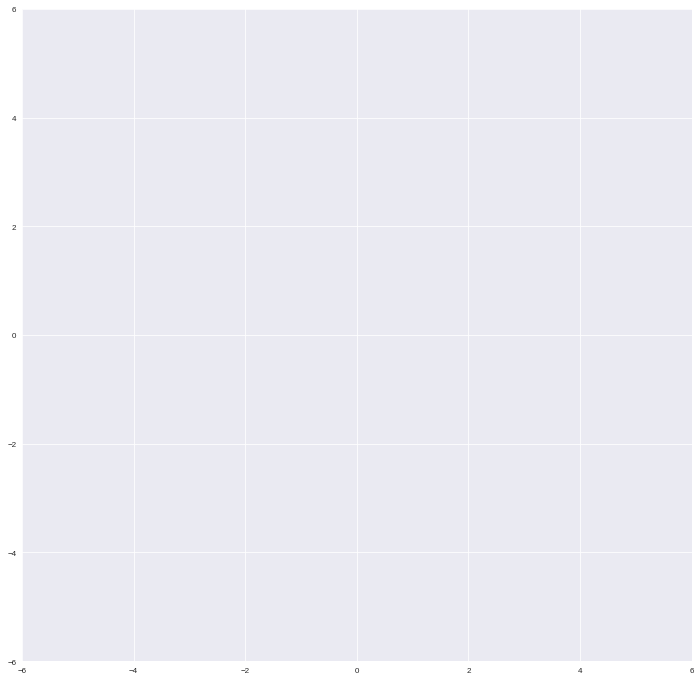

In [19]:
col_1,col_2='pc1','pc2'
alpha=0.05
freedomDegrees=2
plt.figure(figsize=(12,12))
plt.axis([-6,6,-6,6])

biplotSchema = ['pc'+str(k+1) for k in range(0,k)]

transformedWhiteWinneDF = transformedTrainingDF.where(c(labelCol) == lit(0))\
                                               .select(['features']).rdd\
                                               .map(lambda r: [float(r[0].values[i]) for i in range (0,k)])\
                                               .toDF(biplotSchema)

transformedRedWinneDF = transformedTrainingDF.where(c(labelCol) == lit(1))\
                                             .select(['features']).rdd\
                                             .map(lambda r: [float(r[0].values[i]) for i in range (0,k)])\
                                             .toDF(biplotSchema)

scatterPlot(plt,transformedWhiteWinneDF,col_1,col_2,'Gray')
getProbabilityDensityContour(plt,transformedWhiteWinneDF,\
                            [col_1,col_2],alpha,freedomDegrees,\
                             color='Gray',name='Transformed White Winne')

scatterPlot(plt,transformedRedWinneDF,col_1,col_2,'Red')
getProbabilityDensityContour(plt,transformedRedWinneDF,\
                            [col_1,col_2],alpha,freedomDegrees,\
                             color='Red',name='Transformed Red Winne')
plt.show() 

# Discriminant Analysis

In [31]:
testinglabeledVectorsDF = testingDF.crossJoin(f.broadcast(statisticsDF))\
                                   .select([c(labelCol)]+stdExpresions)\
                                   .select(stdSchema+[labelCol]).rdd\
                                   .map(lambda x:(Vectors.dense(x[0:p]-Vectors.dense(meanVector)),x[p]))\
                                   .toDF(['vectors',labelCol])

transformedTestingDF = pcaModel.transform(testinglabeledVectorsDF).select(['features',labelCol])

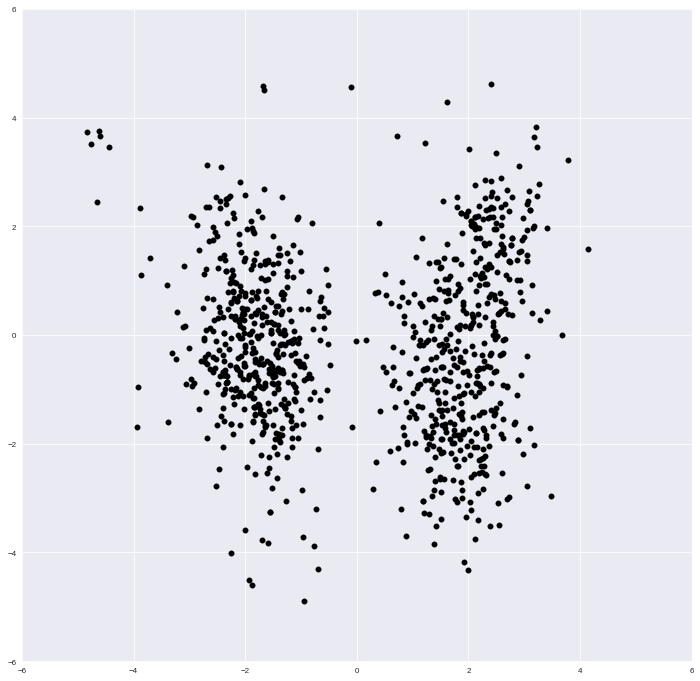

In [32]:
col_1,col_2='pc1','pc2'
alpha=0.05
freedomDegrees=2
plt.figure(figsize=(12,12))
plt.axis([-6,6,-6,6])

biplotSchema = ['pc'+str(k+1) for k in range(0,k)]

biplotMarksDF = transformedTestingDF.select(['features']).rdd\
                                    .map(lambda r: [float(r[0].values[i]) for i in range (0,k)])\
                                    .toDF(biplotSchema)

scatterPlot(plt,biplotMarksDF,col_1,col_2,'Black')

plt.show() 

# Logistic Regression

---

Logistic regression is a statistical method for analyzing a dataset in which there are one or more independent variables that determine an outcome. The outcome is measured with a dichotomous variable (in which there are only two possible outcomes).

In logistic regression, the dependent variable is binary or dichotomous, i.e. it only contains data coded as 1 (TRUE, success, pregnant, etc.) or 0 (FALSE, failure, non-pregnant, etc.).

The goal of logistic regression is to find the best fitting (yet biologically reasonable) model to describe the relationship between the dichotomous characteristic of interest (dependent variable = response or outcome variable) and a set of independent (predictor or explanatory) variables. Logistic regression generates the coefficients (and its standard errors and significance levels) of a formula to predict a logit transformation of the probability of presence of the characteristic of interest:

<img src='static/logist1.png'>

where p is the probability of presence of the characteristic of interest. The logit transformation is defined as the logged odds:

<img src='static/logist2.png'>

and

<img src='static/logist3.png'>

Rather than choosing parameters that minimize the sum of squared errors (like in ordinary regression), estimation in logistic regression chooses parameters that maximize the likelihood of observing the sample values.

In [33]:
from pyspark.ml.classification import LogisticRegression

logisticRegressionModel = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)\
                                   .fit(transformedTrainingDF)

print("Coefficients: " + str(logisticRegressionModel.coefficients))
print("Intercept: " + str(logisticRegressionModel.intercept))

Coefficients: [-0.37554527015,0.0]
Intercept: 0.012010399208992226


In [34]:
probabilitiesDF = logisticRegressionModel.transform(transformedTestingDF)
probabilitiesDF.limit(5).toPandas()

,features,label,rawPrediction,probability,prediction
0,"[1.97973399084, -0.924138649132]",0,"[0.731469337209, -0.731469337209]","[0.675127625665, 0.324872374335]",0.0
1,"[1.89901158466, 0.459745857617]",0,"[0.70115441937, -0.70115441937]","[0.66844367209, 0.33155632791]",0.0
2,"[1.50443010302, -1.92023645968]",0,"[0.552971210251, -0.552971210251]","[0.634824659367, 0.365175340633]",0.0
3,"[2.04411976751, -2.60470730173]",0,"[0.7556491111, -0.7556491111]","[0.680408364266, 0.319591635734]",0.0
4,"[2.06011778796, -0.197446214944]",0,"[0.761657092012, -0.761657092012]","[0.681713398231, 0.318286601769]",0.0


### Wald test for goodness of fit
___
Consider the MLE $\hat{\beta_j}$, by the asymptotic distribution theorem for the MLE, whe have that:

$$
\frac{\hat{\beta_j}-B_0}{\sqrt{V(\hat{\beta_j}})} \sim N(0,1)
\implies \frac{(\hat{\beta_j}-B_0)^2}{V(\hat{\beta_j})} \sim \chi_{(1)}
$$

Where $B_0$ is a fixed value to contrast, usually $B_0 = 0$ to test significance. Its possible to obtain the variance of the MLE vector $(\hat{\beta}_0,\hat{\beta}_1,...,\hat{\beta}_p)$ computing the Fisher information. $\mathbf{I(\beta)}=-E\left[ \nabla^2 ln \mathcal{L}(\beta_0,\beta_1,...,\beta_p) \right]$, computing the partial derivates of second order:

$$
\frac{\partial^2}{\partial \beta_j \partial \beta_k} \mathcal{L}(\beta_0,\beta_1,...,\beta_p) = -\sum_{i=0}^n x_{ij}x_{ik} \frac{e^{\sum_{l=0}^{p} \beta_l x_{il}}}{1+e^{\sum_{l=0}^{p} \beta_l x_{il}}}
$$


# Model Evaluation
---


In discriminant analysis precision (also called **positive predictive value**) is the fraction of relevant instances among the retrieved instances, while recall (also known as **sensitivity**) is the fraction of relevant instances that have been retrieved over the total amount of relevant instances. Both precision and recall are therefore based on an understanding and measure of relevance.

Suppose a computer program for recognizing dogs in photographs identifies eight dogs in a picture containing 12 dogs and some cats. Of the eight dogs identified, five actually are dogs (true positives), while the rest are cats (false positives). The program's precision is 5/8 while its recall is 5/12. When a search engine returns 30 pages only 20 of which were relevant while failing to return 40 additional relevant pages, its precision is 20/30 = 2/3 while its recall is 20/60 = 1/3. So, in this case, precision is "how useful the search results are", and recall is "how complete the results are".

<img src='static/Precisionrecall.png' width=30% height=30%>

In [35]:
binaryLogisticRegressionSummary = logisticRegressionModel.evaluate(transformedTestingDF)

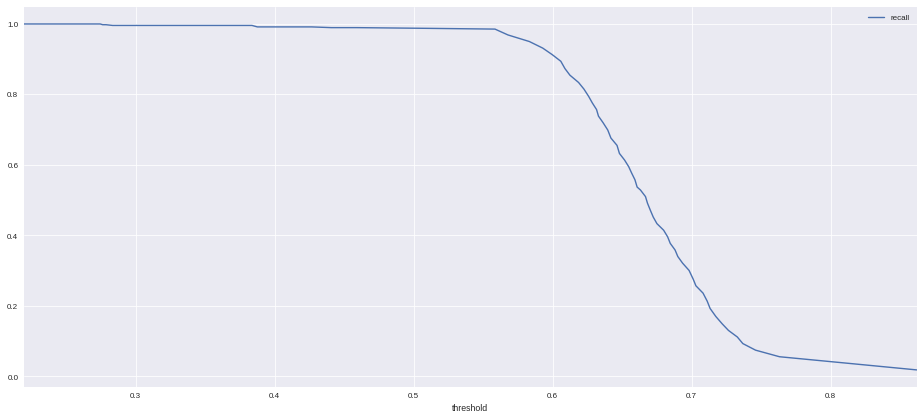

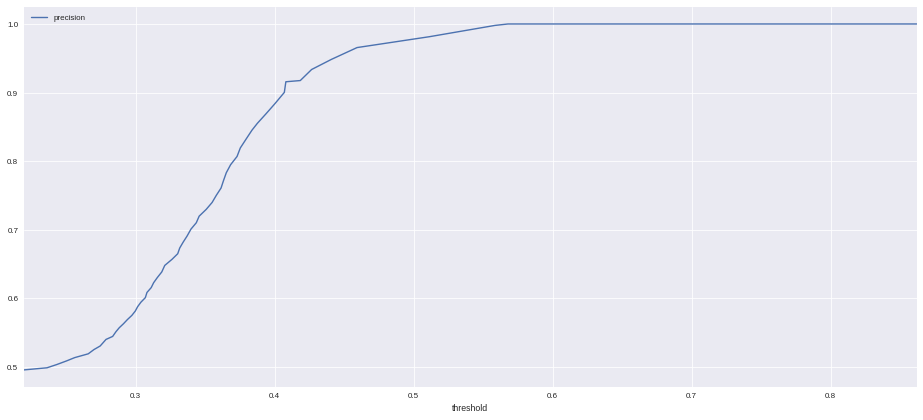

In [36]:
binaryLogisticRegressionSummary.recallByThreshold.orderBy('threshold')\
                               .toPandas()\
                               .plot(x='threshold',y='recall',figsize=(16,7))

binaryLogisticRegressionSummary.precisionByThreshold\
                               .orderBy('threshold').toPandas()\
                               .plot(x='threshold',y='precision',figsize=(16,7))

In [37]:
biplotSchema = ['pc'+str(k+1) for k in range(0,k)]

transformedWhiteWinneDF = probabilitiesDF.where(c('prediction') == lit(0))\
                                         .select(['features']).rdd\
                                         .map(lambda r: [float(r[0].values[i]) for i in range (0,k)])\
                                         .toDF(biplotSchema)

transformedRedWinneDF = probabilitiesDF.where(c('prediction') == lit(1))\
                                       .select(['features']).rdd\
                                       .map(lambda r: [float(r[0].values[i]) for i in range (0,k)])\
                                       .toDF(biplotSchema)

Threshold at 50% of probability desicion boundary

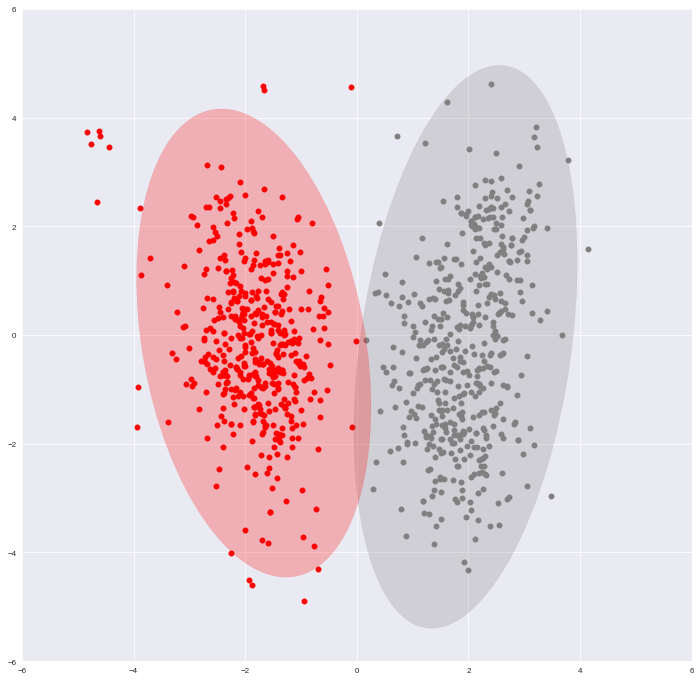

In [38]:
col_1,col_2='pc1','pc2'
alpha=0.05
freedomDegrees=2
plt.figure(figsize=(12,12))
plt.axis([-6,6,-6,6])

scatterPlot(plt,transformedWhiteWinneDF,col_1,col_2,'Gray')
getProbabilityDensityContour(plt,transformedWhiteWinneDF,\
                            [col_1,col_2],alpha,freedomDegrees,\
                             color='Gray',name='Transformed White Winne')

scatterPlot(plt,transformedRedWinneDF,col_1,col_2,'Red')
getProbabilityDensityContour(plt,transformedRedWinneDF,\
                            [col_1,col_2],alpha,freedomDegrees,\
                             color='Red',name='Transformed Red Winne')
plt.show()

In [39]:
binaryLogisticRegressionSummary = logisticRegressionModel.evaluate(transformedTestingDF)
print('Area under roc curve: '+str(binaryLogisticRegressionSummary.areaUnderROC))

Area under roc curve: 0.9954872349595628
